<a href="https://colab.research.google.com/github/DaDosValle/Analise_Preditiva-Machine_Learning-TelecomX/blob/main/Analise_Preditiva_TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **Modelos de classificação de churn (evasão) clientes Telecom X**

#### Quem são os clientes com maior risco de evasão?
#### Quais variáveis mais influenciam esse comportameto?
#### Que tipo de perfil a empresa precisa manter mais próximo?

### - Análise exploratória dos dados.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
dados = pd.read_csv('/content/dados_tratados.csv')

In [3]:
dados.shape

(7043, 18)

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   churn                    7043 non-null   int64  
 1   sexo                     7043 non-null   object 
 2   idoso                    7043 non-null   int64  
 3   possui parceiro          7043 non-null   int64  
 4   possui dependentes       7043 non-null   int64  
 5   tempo contrato           7043 non-null   int64  
 6   servico telefone         7043 non-null   int64  
 7   multiplas linhas         7043 non-null   int64  
 8   servico internet         7043 non-null   object 
 9   suporte tecnico          7043 non-null   int64  
 10  streaming tv             7043 non-null   int64  
 11  streaming filmes         7043 non-null   int64  
 12  contrato conta           7043 non-null   object 
 13  preco diario             7043 non-null   float64
 14  cobrancas mensais       

In [5]:
dados.head()

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,servico internet,suporte tecnico,streaming tv,streaming filmes,contrato conta,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade,churn_label
0,0,Feminino,0,1,1,9,1,0,DSL,1,1,0,Um ano,2.2,65.6,593.3,527.7,Permaneceram
1,0,Masculino,0,0,0,9,1,1,DSL,0,0,1,Mensal,2.0,59.9,542.4,482.5,Permaneceram
2,1,Masculino,0,0,0,4,1,0,Fibra optica,0,0,0,Mensal,2.5,73.9,280.8,207.0,Saíram
3,1,Masculino,1,1,0,13,1,0,Fibra optica,0,1,1,Mensal,3.3,98.0,1237.8,1139.8,Saíram
4,1,Feminino,1,1,0,3,1,0,Fibra optica,1,1,0,Mensal,2.8,83.9,267.4,183.5,Saíram


In [6]:
px.pie(dados, names='churn_label', width=800, title='Distribuição da Variável Alvo: churn')

In [7]:
px.histogram(dados, x='churn_label', text_auto=True, color='churn_label',
            width=800, height=500,
            title='Distribuição da Variável Alvo: churn'
            )


In [8]:
px.histogram(dados, x='sexo', text_auto=True, color='churn_label',
            barmode='group', width=900, height=500,
            title='Distribuição da Variável categórica: sexo')


In [9]:
px.histogram(dados, x = 'idoso', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: idoso'
             )


In [10]:
px.histogram(dados, x = 'possui parceiro', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Alvo: possui parceiro'
             )

In [11]:
px.histogram(dados, x = 'possui dependentes', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: possui dependentes'
             )


In [12]:
px.histogram(dados, x = 'servico telefone', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: servico telefone'
             )

In [13]:
px.histogram(dados, x = 'multiplas linhas', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: multiplas linhas')


In [14]:
dados['servico internet'].value_counts()

,count
servico internet,
Fibra optica,3096
DSL,2421
Nao disponivel,1526


In [15]:
px.histogram(dados, x = 'servico internet', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórico: servico internet')


In [16]:
px.histogram(dados, x = 'suporte tecnico', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: suporte tecnico'
             )


In [17]:
px.histogram(dados, x = 'streaming tv', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: streaming tv'
             )


In [18]:
px.histogram(dados, x = 'streaming filmes', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: streaming filmes'
             )


In [19]:
px.histogram(dados, x = 'contrato conta', text_auto = True, color = 'churn_label',
             barmode = 'group', width=900, height=500,
             title='Distribuição da Variável Categórica: contrato conta'
             )


In [20]:
px.box(dados, x='tempo contrato', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Númércia: tempo contrato'
             )


In [21]:
px.box(dados, x='preco diario', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Numérica: preco diario'
             )


In [22]:
px.box(dados, x='cobrancas mensais', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Numérica: cobrancas mensais')



In [23]:
px.box(dados, x='total de encargos', color='churn_label',
       width=900, height=500,
       title='Distribuição da Variável Numércia: total de encargos')



In [24]:
px.box(dados, x='excedente a mensalidade', color='churn_label',
             width=900, height=500,
             title='Distribuição da Variável Numércia: excedente a mensalidade')


In [25]:
dados.describe().round(2)

,churn,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,suporte tecnico,streaming tv,streaming filmes,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.0,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.27,0.16,0.48,0.30,32.37,0.9,0.42,0.29,0.38,0.39,2.16,64.76,2284.33,2219.56
std,0.44,0.37,0.50,0.46,24.56,0.3,0.49,0.45,0.49,0.49,1.00,30.09,2265.95,2246.51
min,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.60,18.20,18.80,0.00
25%,0.00,0.00,0.00,0.00,9.00,1.0,0.00,0.00,0.00,0.00,1.20,35.50,401.90,355.75
50%,0.00,0.00,0.00,0.00,29.00,1.0,0.00,0.00,0.00,0.00,2.30,70.40,1398.60,1352.20
75%,1.00,0.00,1.00,1.00,55.00,1.0,1.00,1.00,1.00,1.00,3.00,89.80,3801.50,3730.10
max,1.00,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.00,4.00,118.80,8684.80,8567.00


In [26]:
dados.describe(include='O')

,sexo,servico internet,contrato conta,churn_label
count,7043,7043,7043,7043
unique,2,3,3,2
top,Masculino,Fibra optica,Mensal,Permaneceram
freq,3555,3096,3875,5174


In [27]:
dados.head(3)

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,servico internet,suporte tecnico,streaming tv,streaming filmes,contrato conta,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade,churn_label
0,0,Feminino,0,1,1,9,1,0,DSL,1,1,0,Um ano,2.2,65.6,593.3,527.7,Permaneceram
1,0,Masculino,0,0,0,9,1,1,DSL,0,0,1,Mensal,2.0,59.9,542.4,482.5,Permaneceram
2,1,Masculino,0,0,0,4,1,0,Fibra optica,0,0,0,Mensal,2.5,73.9,280.8,207.0,Saíram


### - Prepararando os dados para a modelagem.


In [28]:
dados = pd.get_dummies(dados, columns=[
    'servico internet',
    'contrato conta'
], drop_first=False)

In [29]:
dados['sexo'] = dados['sexo'].map({'Masculino': 1, 'Feminino': 0})

dados['sexo'] = dados['sexo'].astype(int)

In [30]:
colunas = ['servico internet_DSL', 'servico internet_Fibra optica', 'servico internet_Nao disponivel', 'contrato conta_Dois anos', 'contrato conta_Mensal', 'contrato conta_Um ano']

dados[colunas] = dados[colunas].astype(int)

In [31]:
dados.head(3)

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,suporte tecnico,streaming tv,...,cobrancas mensais,total de encargos,excedente a mensalidade,churn_label,servico internet_DSL,servico internet_Fibra optica,servico internet_Nao disponivel,contrato conta_Dois anos,contrato conta_Mensal,contrato conta_Um ano
0,0,0,0,1,1,9,1,0,1,1,...,65.6,593.3,527.7,Permaneceram,1,0,0,0,0,1
1,0,1,0,0,0,9,1,1,0,0,...,59.9,542.4,482.5,Permaneceram,1,0,0,0,1,0
2,1,1,0,0,0,4,1,0,0,0,...,73.9,280.8,207.0,Saíram,0,1,0,0,1,0


In [32]:
dados = dados.drop(['churn_label'], axis=1)

### - Analise de correão entre variáveis.


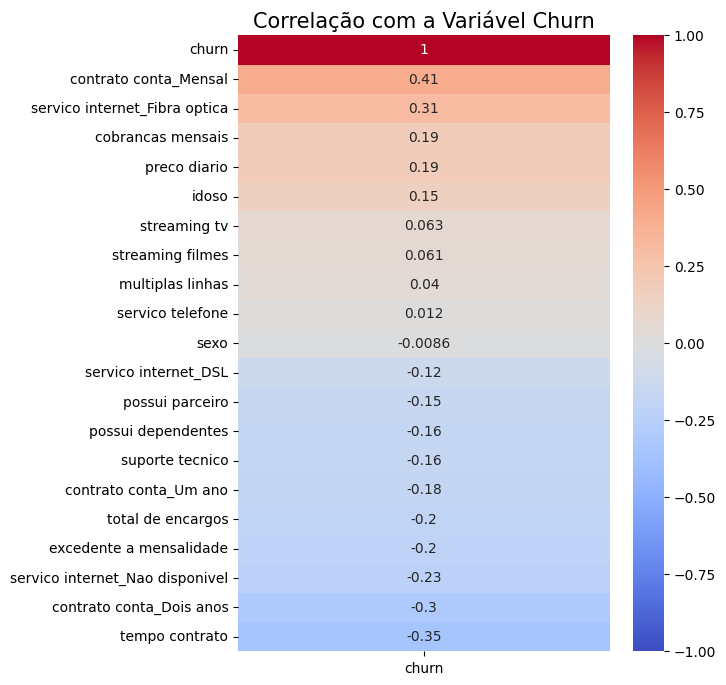

In [33]:
plt.figure(figsize=(6, 8))

# Correlação das variáveis explicativas com a variavel churn
corr_churn = dados.corr(numeric_only=True)[['churn']].sort_values(by='churn', ascending=False)

sns.heatmap(corr_churn, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlação com a Variável Churn', fontsize=15)
plt.show()


In [34]:
# Tratando para evitar multicolinearidade
variaveis_correlacionadas = dados[['tempo contrato','total de encargos','cobrancas mensais']]

variaveis_correlacionadas.corr()

,tempo contrato,total de encargos,cobrancas mensais
tempo contrato,1.000000,0.823814,0.247890
total de encargos,0.823814,1.000000,0.650018
cobrancas mensais,0.247890,0.650018,1.000000


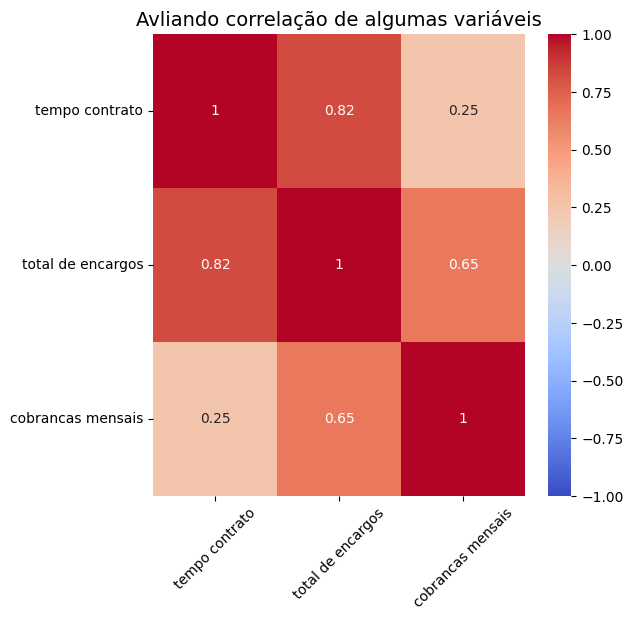

In [35]:
plt.figure(figsize=(6, 6))

# Correlação das variáveis explicativas com a variavel churn
corr_churn_correlacionados = variaveis_correlacionadas.corr(numeric_only=True)

sns.heatmap(corr_churn_correlacionados, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.title('Avliando correlação de algumas variáveis', fontsize=14)
plt.show()


### - Seleção das variáveis

In [36]:
# Seleção da variável resposta/alvo

remover_variaveis = ['total de encargos', 'sexo', 'servico telefone', 'streaming tv', 'streaming filmes', 'churn']

y = dados['churn']

# Seleção das variáveis explicativas
x = dados.drop(remover_variaveis, axis=1)

In [37]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

### -  Treinando e avaliando modelo de base.

In [38]:
dummy = DummyClassifier(strategy='stratified', random_state=101)
dummy.fit(x_treino, y_treino)

round(dummy.score(x_teste, y_teste),2)

0.63

In [39]:
y_pred_dummy = dummy.predict(x_teste)

In [40]:
print(classification_report(y_teste, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1035
           1       0.29      0.28      0.29       374

    accuracy                           0.63      1409
   macro avg       0.52      0.52      0.52      1409
weighted avg       0.63      0.63      0.63      1409



### -  Ajustando e treinando modelo de regressão logistica.

In [44]:
sm = SMOTE(random_state=42)

x_treino_res, y_treino_res = sm.fit_resample(x_treino, y_treino)

In [45]:
scaler = StandardScaler()

x_treino_res_scaled = scaler.fit_transform(x_treino_res)
x_teste_scaled = scaler.transform(x_teste)

In [46]:
log_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
)

log_model.fit(x_treino_res_scaled, y_treino_res)

LogisticRegression(max_iter=1000, random_state=42)

In [47]:
round(log_model.score(x_teste_scaled, y_teste), 2)

0.75

In [48]:
y_pred = log_model.predict(x_teste_scaled)

y_pred

array([0, 1, 1, ..., 1, 0, 0])

In [382]:
y_proba = log_model.predict_proba(x_teste_scaled)[:,1]

threshold = 0.35  # testar 0.4, 0.3, 0.25
y_pred_adjusted = (y_proba >= threshold).astype(int)

### - Avaliando modelo de regressão logistica

In [383]:
accuracy = accuracy_score(y_teste, y_pred_adjusted)
print("Acurácia:", accuracy)

Acurácia: 0.7033356990773598


In [384]:
print(classification_report(y_teste, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.91      0.66      0.77      1035
           1       0.47      0.83      0.60       374

    accuracy                           0.70      1409
   macro avg       0.69      0.74      0.68      1409
weighted avg       0.80      0.70      0.72      1409



In [385]:
cm = confusion_matrix(y_teste, y_pred_adjusted)
print(cm)

[[681 354]
 [ 64 310]]


### - Análise de importância das variáveis regressão logistica

In [386]:
modelo = log_model

In [387]:
coeficientes = pd.DataFrame({
    'Variável': x_treino.columns,
    'Coeficiente': modelo.coef_[0]
})

coeficientes['Impacto Absoluto'] = coeficientes['Coeficiente'].abs()

coeficientes = coeficientes.sort_values(by='Impacto Absoluto', ascending=False)

coeficientes

,Variável,Coeficiente,Impacto Absoluto
12,contrato conta_Dois anos,-2.501971,2.501971
13,contrato conta_Mensal,-2.347975,2.347975
14,contrato conta_Um ano,-2.132158,2.132158
11,servico internet_Nao disponivel,-2.068516,2.068516
9,servico internet_DSL,-2.016482,2.016482
3,tempo contrato,-1.865897,1.865897
10,servico internet_Fibra optica,-1.744827,1.744827
8,excedente a mensalidade,1.157893,1.157893
5,suporte tecnico,-0.439036,0.439036
6,preco diario,-0.313237,0.313237


In [388]:
def plotar_coeficientes(coeficientes_reg, feature_names, top_n=15):
    coeficientes_reg = coeficientes_reg.sort_values(by='Impacto Absoluto', ascending=False)
    top_coeficientes = coeficientes_reg.head(top_n)

    plt.figure(figsize=(7, 8))
    sns.barplot(x='Coeficiente', y='Variável', data=top_coeficientes, palette='viridis')
    plt.title('Top {} Coeficientes da Regressão Logística'.format(top_n))
    plt.xlabel('Coeficiente')
    plt.xticks([])
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)


    for i, value in enumerate(top_coeficientes['Coeficiente']):
        plt.text(value, i, f'{value:.2f}', ha='right', va='center')

    plt.show()
    return coeficientes_reg;

/tmp/ipython-input-34121/7413556.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




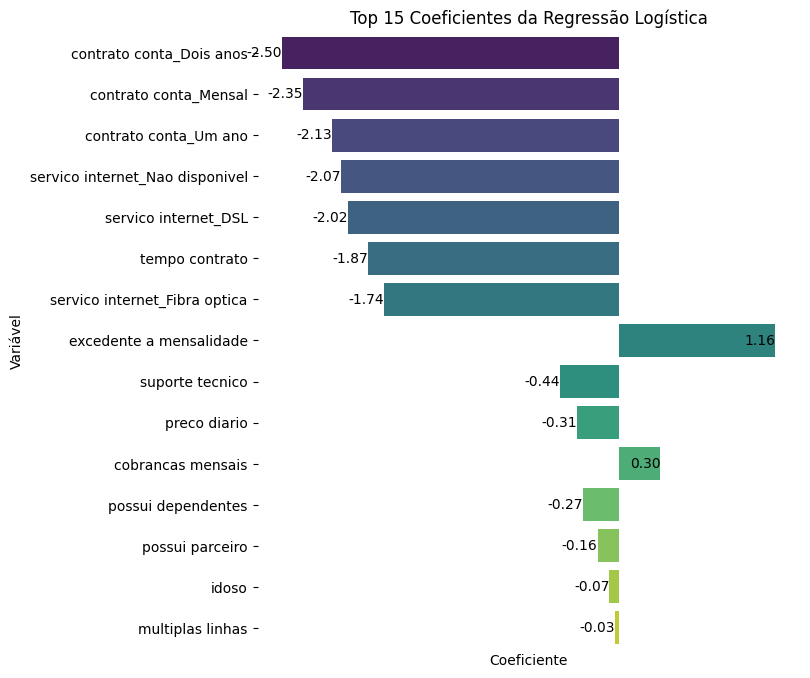

,Variável,Coeficiente,Impacto Absoluto
12,contrato conta_Dois anos,-2.501971,2.501971
13,contrato conta_Mensal,-2.347975,2.347975
14,contrato conta_Um ano,-2.132158,2.132158
11,servico internet_Nao disponivel,-2.068516,2.068516
9,servico internet_DSL,-2.016482,2.016482
3,tempo contrato,-1.865897,1.865897
10,servico internet_Fibra optica,-1.744827,1.744827
8,excedente a mensalidade,1.157893,1.157893
5,suporte tecnico,-0.439036,0.439036
6,preco diario,-0.313237,0.313237


In [389]:
plotar_coeficientes(coeficientes, x_treino.columns)

### -  Treinando modelo de árvore de decisão.

In [429]:
arvore = DecisionTreeClassifier(max_depth = 3, random_state =1875)
arvore.fit(x_treino_res, y_treino_res)

DecisionTreeClassifier(max_depth=3, random_state=1875)

In [430]:
y_pred = arvore.predict(x_teste)

In [431]:
colunas_selecionadas = ['servico internet_DSL',
                'servico internet_Fibra optica',
                'servico internet_Nao disponivel',
                'idoso)',
                'possui parceiro',
                'possui dependentes',
                'tempo contrato',
                'servico telefone',
                'multiplas linhas',
                'suporte tecnico',
                'preco diario',
                'contrato conta',
                'cobrancas mensais',
                'servico internet_DSL',
                'servico internet_Fibra optica',
                'servico internet_Nao disponivel',
                'contrato conta_Dois anos',
                'contrato conta_Mensal',
                'contrato conta_Um ano',
                ]

In [432]:
arvore.score(x_treino_res, y_treino_res)

0.797656438753322

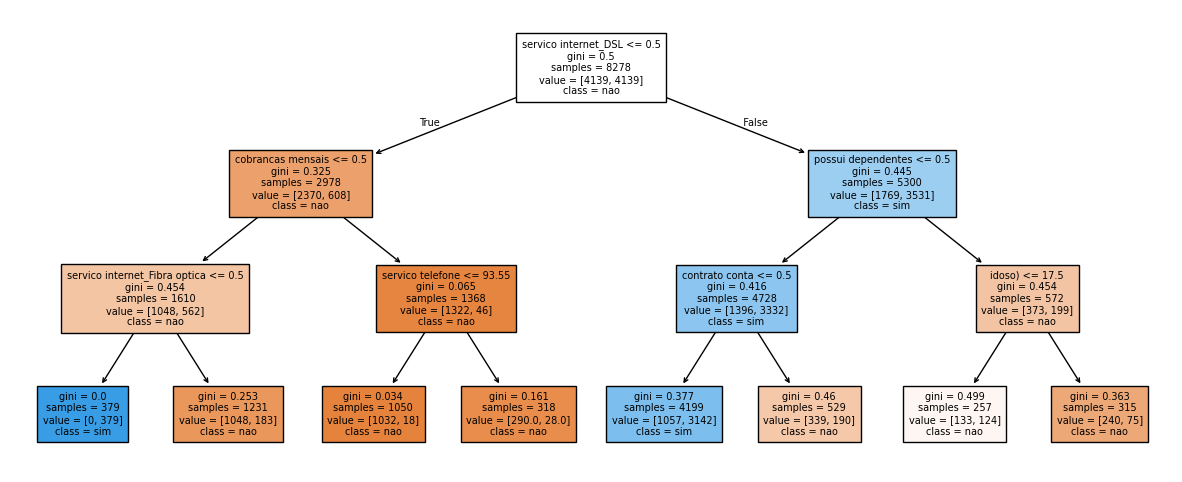

In [433]:
plt.figure(figsize = (15, 6))
plot_tree(arvore, filled = True, class_names = ['nao', 'sim'], fontsize = 7, feature_names = colunas_selecionadas);

### - Avaliando modelo árvore de decisão

In [434]:
accuracy = accuracy_score(y_teste, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.7295954577714692


In [435]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1035
           1       0.49      0.71      0.58       374

    accuracy                           0.73      1409
   macro avg       0.68      0.72      0.69      1409
weighted avg       0.77      0.73      0.74      1409



In [436]:
cm_arvore = confusion_matrix(y_teste, y_pred)
print(cm_arvore)

[[762 273]
 [108 266]]


### - Análise de importância das variáveis árvore de decisão

In [437]:
importancias = pd.DataFrame({
    'Variável': x_treino.columns,
    'Importância': arvore.feature_importances_
})

importancias = importancias.sort_values(by='Importância', ascending=False)

importancias

,Variável,Importância
13,contrato conta_Mensal,0.486654
14,contrato conta_Um ano,0.251085
12,contrato conta_Dois anos,0.087977
11,servico internet_Nao disponivel,0.085036
5,suporte tecnico,0.077674
3,tempo contrato,0.010106
7,cobrancas mensais,0.001467
6,preco diario,0.000000
4,multiplas linhas,0.000000
1,possui parceiro,0.000000


### -  Treinando modelo de SVM.

In [438]:
svm = SVC(random_state=42)

In [439]:
svm.fit(x_treino_res_scaled, y_treino_res)

SVC(random_state=42)

### - Avaliando modelo smv

In [440]:
y_pred_svm = svm.predict(x_teste_scaled)

print("Acurácia:", accuracy_score(y_teste, y_pred))

Acurácia: 0.7295954577714692


In [441]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1035
           1       0.49      0.71      0.58       374

    accuracy                           0.73      1409
   macro avg       0.68      0.72      0.69      1409
weighted avg       0.77      0.73      0.74      1409



In [442]:
cm_svm = confusion_matrix(y_teste, y_pred)
print(cm_svm)

[[762 273]
 [108 266]]


### - Análise de importância das variáveis SVM

In [443]:
SVC(kernel='linear')

SVC(kernel='linear')

In [444]:
coeficientes_svm = pd.DataFrame({
    'Variável': x_treino.columns,
    'Coeficiente': modelo.coef_[0]
})

coeficientes_svm['Impacto Absoluto'] = coeficientes_svm['Coeficiente'].abs()

coeficientes_svm = coeficientes_svm.sort_values(by='Impacto Absoluto', ascending=False)

coeficientes_svm

,Variável,Coeficiente,Impacto Absoluto
12,contrato conta_Dois anos,-2.501971,2.501971
13,contrato conta_Mensal,-2.347975,2.347975
14,contrato conta_Um ano,-2.132158,2.132158
11,servico internet_Nao disponivel,-2.068516,2.068516
9,servico internet_DSL,-2.016482,2.016482
3,tempo contrato,-1.865897,1.865897
10,servico internet_Fibra optica,-1.744827,1.744827
8,excedente a mensalidade,1.157893,1.157893
5,suporte tecnico,-0.439036,0.439036
6,preco diario,-0.313237,0.313237


# **Relatório de Análise Preditiva – Evasão de Clientes (Churn)**


**Data:** 25/02/2026

**Empresa:** Telecom X

**Responsável:** Fernando do Valle

## **Objetivo do Projeto**

O objetivo deste estudo foi identificar os principais fatores que influenciam a evasão de clientes (churn) na empresa TelecomX, utilizando técnicas de Machine Learning para:



- Prever a probabilidade de evasão

- Identificar variáveis mais relevantes

- Comparar o desempenho de diferentes modelos

- Propor estratégias de retenção baseadas em dados

## **Modelos Utilizados**

Foram treinados e avaliados três modelos de classificação:

1. Regressão Logística

2. Árvore de Decisão

3. SVM (Support Vector Machine)

A divisão dos dados foi feita com:

80% treino

20% teste

Estratificação da variável alvo

## **Avaliação dos Modelos**

### **Regressão Logística**

Acurácia: 78,7%


In [445]:
cm = confusion_matrix(y_teste, y_pred)
print(cm)

[[762 273]
 [108 266]]


Principais métricas para churn (classe 1):

- Precisão: 62%

- Recall: 49%

- F1-score: 55%

#### **Interpretação:**

O modelo apresenta boa capacidade geral de classificação, mas identifica apenas 49% dos clientes que realmente evadem, o que indica espaço para melhoria na detecção de churn.

### **Árvore de decisão**

Acurácia: 79,4%

In [446]:
cm_arvore = confusion_matrix(y_teste, y_pred)
print(cm_arvore)

[[762 273]
 [108 266]]


Principais métricas para churn (classe 1):

- Precisão: 70%

- Recall: 39%

- F1-score: 50%

#### **Interpretação:**

A árvore apresentou levemente melhor acurácia, porém recall inferior na classe de evasão, indicando maior dificuldade em capturar clientes que realmente cancelam.

### **SVM (Support Vector Machine)**

O modelo SVM apresentou resultados idênticos à Árvore de Decisão na execução registrada, indicando possível reutilização de variável de predição no código.
Recomenda-se revisar a variável y_pred utilizada na avaliação.

## **Principais Fatores que Influenciam a Evasão**

A análise foi feita utilizando:

- Coeficientes da Regressão Logística

- Importância das variáveis na Árvore de Decisão

### Variáveis mais relevantes (Regressão Logística)

/tmp/ipython-input-34121/7413556.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




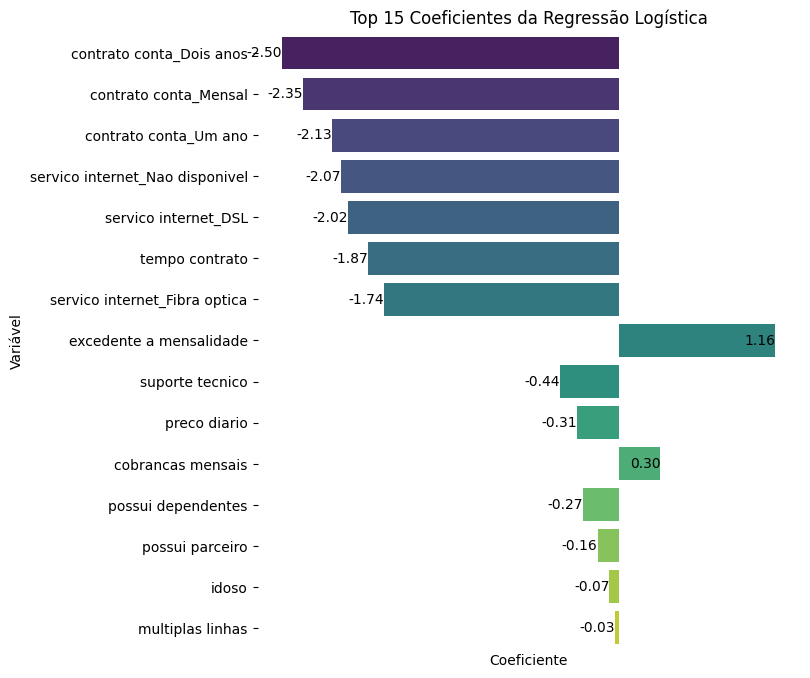

,Variável,Coeficiente,Impacto Absoluto
12,contrato conta_Dois anos,-2.501971,2.501971
13,contrato conta_Mensal,-2.347975,2.347975
14,contrato conta_Um ano,-2.132158,2.132158
11,servico internet_Nao disponivel,-2.068516,2.068516
9,servico internet_DSL,-2.016482,2.016482
3,tempo contrato,-1.865897,1.865897
10,servico internet_Fibra optica,-1.744827,1.744827
8,excedente a mensalidade,1.157893,1.157893
5,suporte tecnico,-0.439036,0.439036
6,preco diario,-0.313237,0.313237


In [447]:
plotar_coeficientes(coeficientes, x_treino.columns)

### Variáveis mais relevantes (árvore de decisão)

1. Contrato mensal (61% da importância total)

2. Tempo de contrato

3. Internet Fibra Óptica

4. Cobrança mensal

## **Principais Insights Estratégicos**

### 1. Tipo de contrato é o fator mais determinante

Clientes com contrato mensal têm probabilidade significativamente maior de evasão.

Clientes com contrato de dois anos apresentam risco muito menor.

### 2. Tempo de relacionamento reduz churn

Quanto maior o tempo de contrato, menor a probabilidade de evasão.

Isso indica que fidelização ao longo do tempo é um fator protetor.

### 3. Valor da mensalidade influencia fortemente

- Cobranças mensais elevadas aumentam o risco.

- Excedentes de cobrança também impactam negativamente.

- Preço diário elevado está associado à saída.

### 4. Internet Fibra Óptica apresenta maior evasão

Pode indicar:

- Expectativa não atendida

- Problemas de qualidade

- Alta competitividade nesse segmento

### 5. Suporte técnico reduz evasão

Clientes que utilizam ou possuem suporte técnico apresentam menor probabilidade de churn.

### 6.Estratégias de Retenção Propostas

Com base nos resultados, recomenda-se:

1. Incentivar migração para contratos longos

- Oferecer desconto para migração de contrato mensal para anual/bienal

- Criar benefícios exclusivos para contratos longos

2. Programa de retenção nos primeiros meses

Clientes com pouco tempo de contrato são mais vulneráveis.

___

Ações:

- Onboarding estruturado

- Contato proativo nos primeiros 90 dias

- Ofertas personalizadas

___

3. Revisão da política de cobrança

- Reduzir impacto de excedentes

- Oferecer planos mais ajustados ao perfil de consumo

- Alertas preventivos de ultrapassagem

___


4. Monitoramento do serviço de fibra óptica

- Avaliar qualidade do serviço

- Investigar reclamações

- Melhorar experiência do cliente

___

5. Fortalecer suporte técnico

- Tornar suporte mais acessível

- Atendimento proativo para clientes de alto risco

- Uso do modelo para identificar clientes propensos à evasão e acionar suporte antecipadamente

## **7. Conclusão Executiva**

O estudo identificou que o tipo de contrato, o tempo de relacionamento e o valor das cobranças mensais são os principais fatores que influenciam a evasão na TelecomX.

Embora os modelos apresentem acurácia próxima de 79%, ainda existe dificuldade na identificação completa dos clientes que irão cancelar (recall abaixo de 50% na maioria dos casos).

A Regressão Logística demonstrou melhor equilíbrio interpretativo e explicativo, sendo recomendada como modelo base para decisões estratégicas, principalmente pela clareza na interpretação dos coeficientes.

A implementação das estratégias propostas pode reduzir significativamente a evasão e aumentar o lifetime value dos clientes.